# Image Colorization Demo

This notebook demonstrates the image colorization system built on the Needle framework.

## Overview
- Load a trained colorization model
- Colorize grayscale CIFAR-10 images
- Visualize results and compare with ground truth
- Compute evaluation metrics (SSIM, PSNR, L1 error)


In [1]:
import sys
sys.path.append('./python')

import needle as ndl
import needle.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline


## Load Dataset


In [2]:
# Load CIFAR-10 test dataset
test_dataset = ndl.data.CIFAR10Dataset(
    base_folder="./data/cifar-10-batches-py",
    train=False
)

# Wrap with colorization dataset
test_color_dataset = ndl.data.ColorizationDataset(test_dataset)

print(f"Test samples: {len(test_color_dataset)}")


Test samples: 10000


## Load Trained Model


In [3]:
# Initialize model
device = ndl.cpu()
dtype = "float32"

model = nn.ColorizationModel(device=device, dtype=dtype)

# For demo purposes without training, we'll use a randomly initialized model
print("Using initialized model (train first for better results)")


Using initialized model (train first for better results)


## Helper Functions for Visualization


In [4]:
def lab_to_rgb_numpy(lab):
    """Convert Lab to RGB using numpy. lab: (C, H, W) or (H, W, C)"""
    if lab.shape[0] == 3:
        lab = np.transpose(lab, (1, 2, 0))
    
    L, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]
    
    # Lab to XYZ
    fy = (L + 16.0) / 116.0
    fx = a / 500.0 + fy
    fz = fy - b / 200.0
    
    epsilon = 0.008856
    kappa = 903.3
    
    xr = np.where(fx**3 > epsilon, fx**3, (116.0 * fx - 16.0) / kappa)
    yr = np.where(L > kappa * epsilon, ((L + 16.0) / 116.0)**3, L / kappa)
    zr = np.where(fz**3 > epsilon, fz**3, (116.0 * fz - 16.0) / kappa)
    
    X, Y, Z = xr * 0.95047, yr * 1.0, zr * 1.08883
    xyz = np.stack([X, Y, Z], axis=-1)
    
    # XYZ to RGB
    M_inv = np.array([[ 3.2404542, -1.5371385, -0.4985314],
                      [-0.9692660,  1.8760108,  0.0415560],
                      [ 0.0556434, -0.2040259,  1.0572252]])
    
    rgb = np.dot(xyz, M_inv.T)
    mask = rgb > 0.0031308
    rgb = np.where(mask, 1.055 * np.power(rgb, 1.0/2.4) - 0.055, 12.92 * rgb)
    
    return np.clip(rgb, 0, 1)


## Visualize Colorization Results


ValueError: too many values to unpack (expected 2, got 3)

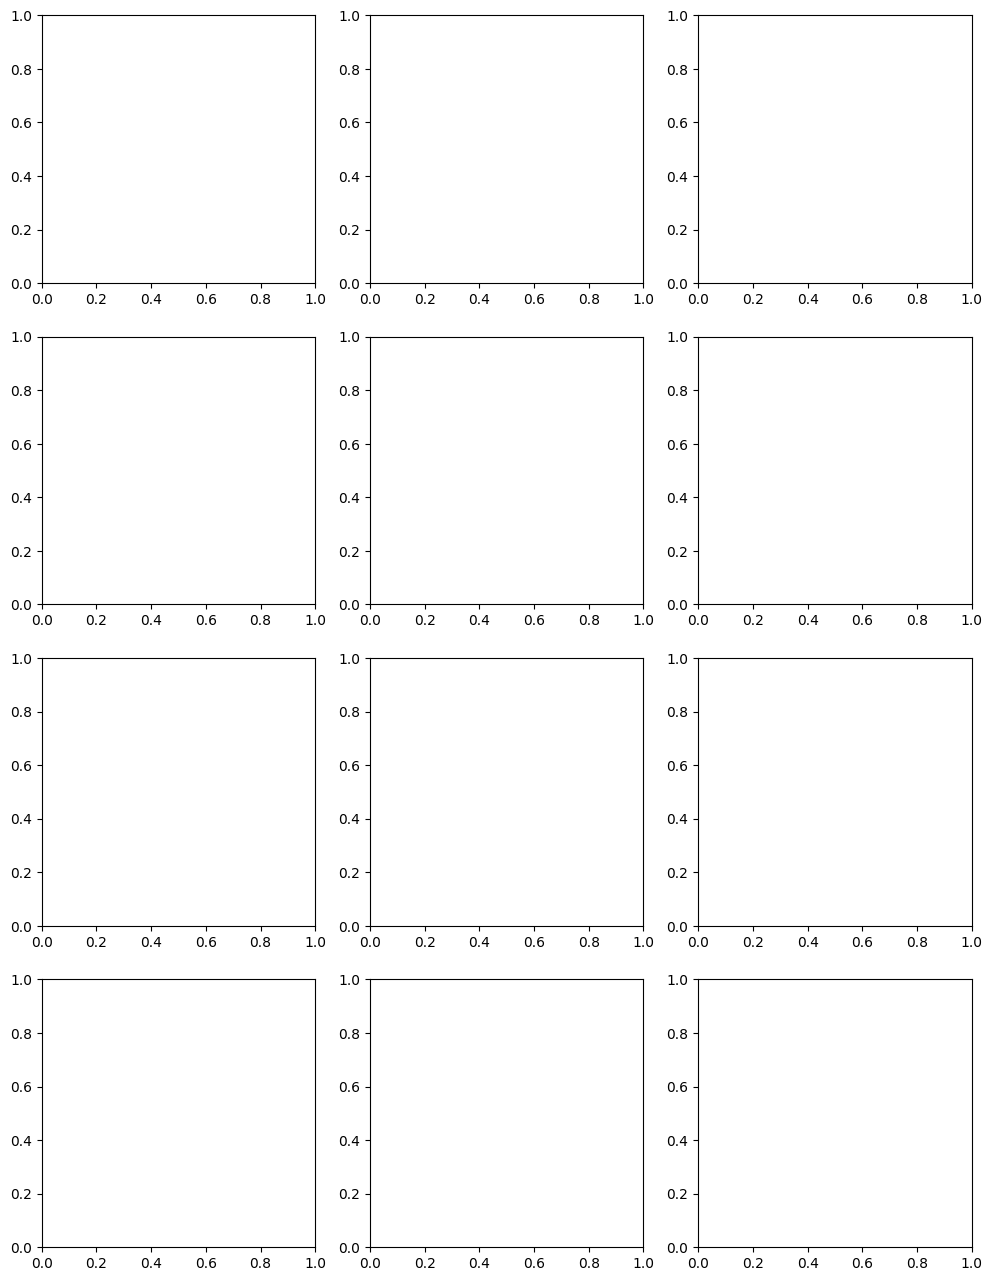

In [5]:
# Select random samples
num_samples = 4
indices = np.random.choice(len(test_color_dataset), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

for i, idx in enumerate(indices):
    # Get data
    gray, ab_target = test_color_dataset[idx]
    
    # Get original RGB
    rgb_original, _ = test_dataset[idx]
    rgb_original = np.transpose(rgb_original, (1, 2, 0))
    
    # Convert to tensor and predict
    gray_tensor = ndl.Tensor(gray.reshape(1, 1, 32, 32), device=device, dtype=dtype)
    ab_pred = model.predict_ab(gray_tensor).numpy()[0]
    
    # Reconstruct Lab and convert to RGB
    L = gray[0] * 100.0
    lab_pred = np.concatenate([L[np.newaxis, :, :], ab_pred], axis=0)
    rgb_pred = lab_to_rgb_numpy(lab_pred)
    
    # Plot
    axes[i, 0].imshow(gray[0], cmap='gray')
    axes[i, 0].set_title('Grayscale Input')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(rgb_pred)
    axes[i, 1].set_title('Colorized (Predicted)')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(rgb_original)
    axes[i, 2].set_title('Ground Truth')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('colorization_results.png', dpi=150, bbox_inches='tight')
plt.show()
